In [22]:
from __future__ import division
from utils import *
from functions import *
from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png', 'pdf')
set_matplotlib_formats('png')

%matplotlib inline
%load_ext autoreload
%autoreload 2
today = datetime.date.today()
todayStr = '%04d%02d%02d' % (today.year, today.month, today.day)
# todayStr = '20151005'
# todayStr = '20160122'
DIRECTORY = os.path.expanduser("~/Dropbox/0000 - PhD/figures/"+todayStr+"/")
if not os.path.exists(DIRECTORY):
    os.makedirs(DIRECTORY)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
from bokeh.io import output_notebook
from bokeh.plotting import figure, show
output_notebook()

# Instantiate classes
cortex = Cortex()
trn = TRN()
gr = GRAPH()

BokehJS successfully loaded.

In [24]:
def xax(gamma, duration):
    x= np.arange(0,(duration)/1000,(duration)/1000/len(gamma) )
    return x

def readPSTH( N, r, G, S, it,
             binsize, d1, d2,
             d3, before, after,
             s, WII, LTP, LTD, model, coeff, RON='izh', tau_m=10):
    gr = GRAPH()
    listSSP1 = Parallel(n_jobs=num_cores)(delayed(cortex.readSimulationSSP1)(N, r,i,G,S,
                                                                           d1, d2, d3, before, after,
                                                                           WII, LTP, LTD, model) for i in range(it))
    if RON == 'izh':
        listS = Parallel(n_jobs=num_cores)(delayed(gr.readoutSpikes)(ssp1, coeff, tau_m) for ssp1 in listSSP1)
    else:
        listS = Parallel(n_jobs=num_cores)(delayed(readoutSpikesIAF)(ssp1, coeff, tau_m) for ssp1 in listSSP1)

    tot = np.sum(listS, axis=0)
    totSSP1 = np.sum(listSSP1, axis=0)
    total = np.sum(listS)
    h = cortex.getHist(tot,binsize)
    hSSP1 = cortex.getHist(totSSP1,binsize)
    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, gamma, correlation, ssp1, stimulation,p,q,lowsp,vm = gr.readSimulation(N,r,0,G,S, d1, d2, d3, before, after, WII, LTP, LTD, model)

    return h, stimulation, total, hSSP1

def plotPTSH( fig, before, after,binsize, h, s, it, DIRECTORY, S, N):
    T = before+after
    simsize=T/0.25
    x2 = np.arange(0,(simsize/4-1)/1000, (simsize/len(s)/4)/1000)

    # fig = plt.figure(figsize=(9,5))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    ax0 = plt.subplot(gs[0])
    # ax0.set_ylim([0,10])
    print(np.arange(0,simsize/1000-binsize/1000,simsize/len(h)/1000).shape)
    print(np.array(h).shape)
    print(binsize/1000)
    ax0.bar(np.arange(0,simsize/1000-binsize/1000,simsize/len(h)/1000),np.array(h)/it, binsize/1000)

    ax0.set_title('PSTH - Input: %s' % S)
    ax0.set_xticks([])

    # plot stimulation s
    ax = plt.subplot(gs[1])
    ax.set_ylim([30,110])
    ax.set_yticks([30,100])
    ax.set_xlabel('Time [s]')
    plt.plot(x2,s)
    plt.tight_layout()
    extension = "_S-%d_N-%d_T-%d" % (S, N, T)
    print(DIRECTORY + extension + '_PTSH.pdf')
    plt.savefig(DIRECTORY + extension + '_PTSH.pdf')
    
def readoutSpikesIAF( ssp1, W, sigma, tau_m=10):
    ## setup parameters and state variables
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time

    ## LIF properties
    Vm      = np.zeros(len(time))    # potential (V) trace over time
    spikes  = np.zeros(len(time))
    np.random.seed(None) # for joblib otherwise, take the same RandomState
    Rm      = W*np.random.lognormal(3, sigma )                 # resistance (kOhm)
#     Rm = W
    Cm      = 7                  # capacitance (uF)
    tau_m   = tau_m               # time constant (msec)
    tau_ref = 4                   # refractory period (msec)
    Vth     = 1                   # spike threshold (V)
    V_spike = 0.5                 # spike delta (V)

    ## Stimulus
    I       = ssp1                 # input current (A)     
    ## iterate over each time step
    for i, t in enumerate(time):
        if t > t_rest:
            Vm[i] = Vm[i-1] + (-Vm[i-1] + I[i]*Rm) / tau_m * dt
        if Vm[i] >= Vth:
            Vm[i] += V_spike
            t_rest = t + tau_ref
    # plt.plot(Vm)
    spikes = Vm>1.4
        
    return spikes

def ron_net(ssp1, W, var, N,  tau_m=10, model=""):
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25                # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    spikes  = np.zeros(len(time))
    if model=="aEIF":
        sp = Parallel(n_jobs=num_cores)(delayed(aEIF)(ssp1, W, var,tau_m) for k in range(N))
    elif model == "IAF":
        sp = Parallel(n_jobs=num_cores)(delayed(readoutSpikesIAF)(ssp1, W, var,tau_m) for k in range(N))
    else:
        sp = Parallel(n_jobs=num_cores)(delayed(readoutSpikesIAF)(ssp1, W, var,tau_m) for k in range(N))

    spikes = np.sum(sp,axis=0)
#     print(spikes.shape)
    return spikes

def plotIAF( ssp1, W,sigma, tau_m=40):
    ## setup parameters and state variables
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time

    ## LIF properties
    Vm      = np.zeros(len(time))    # potential (V) trace over time
    spikes  = np.zeros(len(time))
    Rm      = W*np.random.lognormal(3, sigma )                  # resistance (kOhm)
    Cm      = 7                  # capacitance (uF)
    tau_m   = tau_m               # time constant (msec)
    tau_ref = 4                   # refractory period (msec)
    Vth     = 1                   # spike threshold (V)
    V_spike = 0.5                 # spike delta (V)
    print(Rm)
    ## Stimulus
    I       = ssp1                 # input current (A)     
    ## iterate over each time step
    for i, t in enumerate(time):
        if t > t_rest:
            Vm[i] = Vm[i-1] + (-Vm[i-1] + I[i]*Rm) / tau_m * dt
        if Vm[i] >= Vth:
            Vm[i] += V_spike
            t_rest = t + tau_ref
    plt.plot(Vm)
    
def aEIF( ssp1, W,sigma, tau_m=40):
    
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time
    spikes  = np.zeros(len(time))
    Vm      = np.zeros(len(time)) 
    np.random.seed(None) # for joblib otherwise, take the same RandomState
    Rm      = W*np.random.lognormal(3, sigma )                 # resistance (kOhm)
    refrac  =5/dt
    Delta_T = 0.5
    ref = 0
    c_m = 40
    g_m = 1
    alpha_w = -2
    beta_ad = 15.5
    ad = 0
    tau_ad = 10
    I = ssp1
    vt = 10
    for i, t in enumerate(time):       
        Vm[i]= Vm[i-1]+(ref>refrac)*(dt/c_m*(-g_m*Vm[i-1]+ g_m*Delta_T*np.exp((Vm[i-1]-vt)/Delta_T) +alpha_w*ad +Rm*I[i]))# aEIF neuron model
        ad = ad + (ref>refrac)*(dt/tau_ad*(-ad+beta_ad*Vm[i-1]))# adaptation variable
        vv =(Vm[i]>=vt)# spike if voltage crosses the threshold
        ref = ref*(1-vv)+1 # update of the refractory period
        ad = ad+vv*(30) # spike-triggered adaptation
        spikes[i] = Vm[i]>vt
        Vm[i] = (Vm[i]<vt)*Vm[i] # reset after spike
        
    return spikes
    
def findIndex2(spikes_x,val):
    res = (spikes_x-val).argmin()
    return res

def izhRS(ssp1, W,sigma, tau_m=40):
    T   = len(ssp1)/4             # total time to simulate (msec)
    dt      = 0.25               # simulation time step (msec)
    time    = np.arange(0, T, dt) # time array
    t_rest  = 0                   # initial refractory time
    spikes  = np.zeros(len(time))
    v       = np.zeros(len(time)) 
    u = 0 
    Rm = W
    I = ssp1
    
    for i, t in enumerate(time):
        v[i] += dt/40 * ( 0.7*(v[i-1]+60)*(v[i-1]+40) - u + Rm*I[i])
        u += dt * 0.005 * (-4* (v[i-1] +60) - u)
        if v[i]>35:
            spikes[i]=1
            v[i] = -50
            u += 100
    
    return spikes


In [31]:
S = 140
ratio = 17

N = 2500
G = 4.8
d1 = 10000
d2 = 10000
d3 = 10000
before = d1+d2
after = d3

sigma = 60
WII = 500
FACT = 1

r=0.8
model = "gp-izh"
it = 8
binsize=1000
coeff=1
# fig = plt.figure(figsize=(6,2))


# ints = []
# for S in range(0,20,2):
#     cortex.runPSTH(N=N, r=r, G=G,S=S*10, it=it,binsize=binsize, d1=d1, d2=d2, d3=d3, before=before, after=after,s=sigma,
#                WII=WII, LTP=LTP, LTD=LTD, model=model)
# for S in range(0,20,2):
#     h,s, total,s2, SSP = cortex.readPSTH(N,r, G,S*10, it,binsize, d1, d2, d3, before, after, sigma, WII, LTP, LTD, model,coeff,RON='IAF', tau_m = 1)
#     plotPTSH(fig, before, after,binsize, h, s, it, DIRECTORY, S*10, N)
# #     ints.append(total)
#     gr.savePTSH(before, after, h, s, it, DIRECTORY, S*10, N)
#     extension = "_S-%d_N-%d_T-%d" % (S, N, before+after)
#     plt.savefig(DIRECTORY + extension + '_PTSH.pdf')
#     spikes_x, spikes_y, spikes_x_tc, spikes_y_tc,\
#     gamma, correlation, ssp1, stimulation,\
#     p,q,lowsp,vm = cortex.readSimulation(N, r, 0, G, S*10, d1, d2, d3, before, after, WII, LTP, LTD, model, )
#     plt.figure()
#     plt.plot(gamma)
#     plt.savefig(DIRECTORY + 'gammaPTSH-S%d.pdf'%(S*10))

## SAVE LFP (mean over 8 trials) in SSP list

In [32]:
SSP = []
SPX = []
SPY = []
# for S in range(0,20,2):
#     spikes_x, spikes_y, _, _, _, _, _, _,_,_,_,_  = cortex.readSimulation(N, r, 0, G, 10*S, d1, d2, d3, before, after, WII, LTP, LTD, model, )
#     SPX.append(spikes_x)
#     SPY.append(spikes_y)
#     _,_,_,_,ssp  = cortex.readPSTH(N,r, G,S*10, it,binsize, d1, d2, d3, before, after, sigma, WII, LTP, LTD, model,coeff,RON='IAF', tau_m = 1)
#     SSP.append(ssp)
S = 120
N = 2500
ratio = 15

FACT = 1
LTD  = 4.7e-6 * FACT * N
LTP = ratio * LTD

spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, gamma, correlation, ssp1, stimulation,p,q,lowsp,vm = cortex.readSimulation(N,r, 0, G, S, d1, d2, d3, before, after, WII, LTP, LTD, model)
SPX.append(spikes_x)
SPY.append(spikes_y)
SSP.append(ssp1)
np.save(DIRECTORY +"SSP",SSP)
np.save(DIRECTORY +"SPX",SPX)
np.save(DIRECTORY +"SPY",SPY)


## LOAD SSP

In [33]:
SSP = np.load(DIRECTORY+"SSP.npy")
SPX = np.load(DIRECTORY+"SPX.npy")
SPY = np.load(DIRECTORY+"SPY.npy")

## PLOT SSP_i

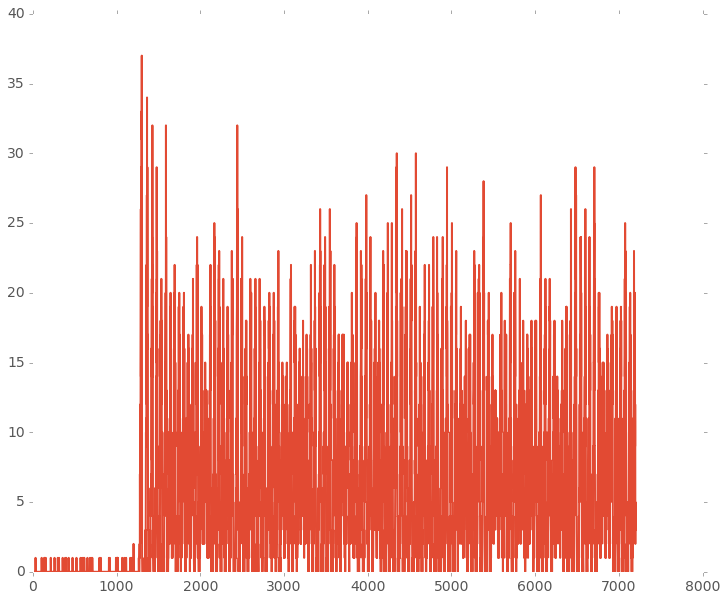

In [34]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1,1,1)
ax.plot(SSP[0][9700*4:11500*4])
plt.savefig(DIRECTORY + "_network_response-short.pdf")

## PLOT RON_i

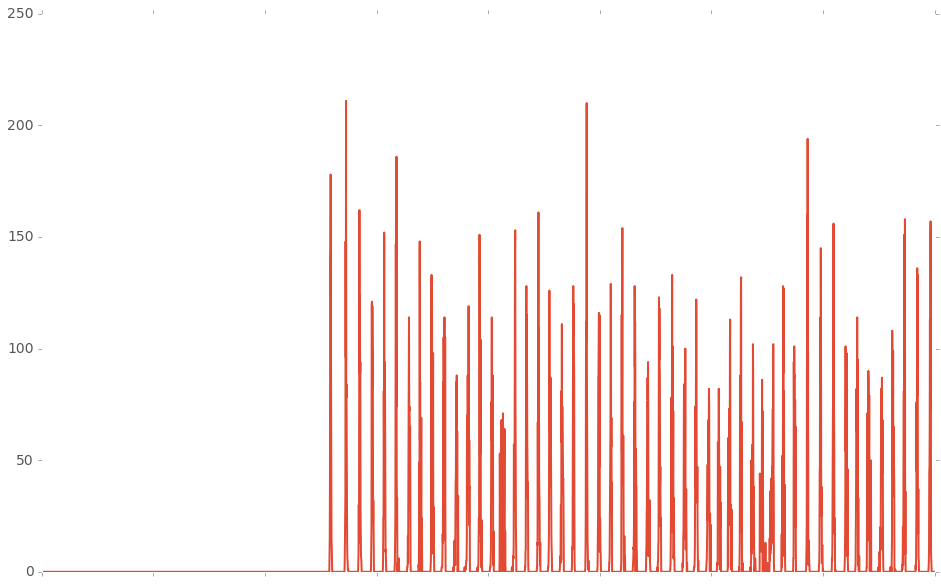

In [35]:
fig = plt.figure(figsize=(16,10))
start =9700
RON =[]
var=0.2
for i in range(0,1):
    ax = fig.add_subplot(1,1,1)
#     ax.set_ylim([0,80])
    if i<8: ax.set_xticklabels([])
    if i%2==1: ax.set_yticklabels([])
#     ax.text(5000,1600,i*20)
    RON.append(ron_net(SSP[i][start*4:(start+1000)*4], 0.01, var, 800, 10, model="IAF"))

ax.plot(RON[0])
np.save(DIRECTORY+'RON-%s'%str(var), RON)
plt.savefig(DIRECTORY + "_RON-10-adEX-%s.pdf"%str(var))

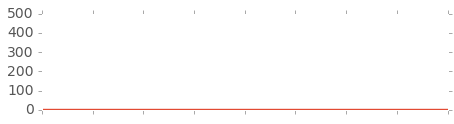

In [36]:
fig = plt.figure(figsize=(16,10))
start =19700
RON =[]
var =0.5
for i in range(0,len(SSP)):
    ax = fig.add_subplot(5,2,1+i)
    ax.set_ylim([0,500])
    if i<8: ax.set_xticklabels([])
    if i%2==1: ax.set_yticklabels([])
#     ax.text(5000,1600,i*20)
    RON.append(ron_net(SSP[i][start*4:(start+4000)*4], 0.017, var, 800, 10, model="aEIF"))
#     ax.plot(cortex.getHist(RON,25), linewidth=1)
    ax.plot(RON[i])
np.save(DIRECTORY+'RON-%s'%str(var), RON)
plt.savefig(DIRECTORY + "_RON-10-adEX-%s.pdf"%str(var))

/Users/GP1514/Dropbox/0000 - PhD/figures/20160224/ron_9700


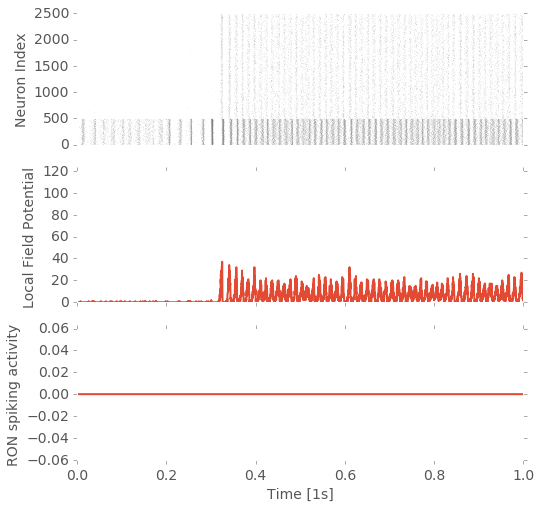

In [37]:
# ## plot beginning stimulation

# fig = plt.figure(figsize=(16,10))
# start =19900
# dur =1000
# RON =[]
# i=4
# W = 0.035

# # RASTER
# ax = fig.add_subplot(3,1,1)
# ax.set_ylabel('Neuron Index')
# starti = findIndex2(SPX[i], start)
# end = findIndex2(SPX[i], start+dur)
# ax = gr.plotRaster(SPX[i][starti:end],SPY[i][starti:end], ax)

# ## RON
# ax = fig.add_subplot(3,1,3)
# ax.set_xticklabels([])
# ax.set_ylabel('Downstream neuron spiking activity')
# network = SSP[i][start*4:(start+dur)*4]
# RON=(readoutSpikesIAF(network, W, 0.9, 40))
# ax.plot(RON)

# ## LFP
# ax = fig.add_subplot(3,1,2)
# ax.set_ylim([0,120])
# ax.plot(xax(network,dur), network)
# plt.savefig(DIRECTORY + 'ron_%s'%str(start))

# ## plot once gap junction are depressed


# start =29700
# dur =1000

# i=2




def plotFigure5(i, SSP, SPX, SPY, start, dur, w):
    fig = plt.figure(figsize=(8,8))
    RON =[]
    # RASTER
    ax = fig.add_subplot(3,1,1)
    ax.set_ylabel('Neuron Index')
    starti = findIndex2(SPX[i], start)
    end = findIndex2(SPX[i], start+dur)
    ax = gr.plotRaster(SPX[i][starti:end],SPY[i][starti:end], ax)

    # RON
    ax = fig.add_subplot(3,1,3)
    ax.set_ylabel('RON spiking activity')
    ax.set_xlabel('Time [1s]')
    network = SSP[i][start*4:(start+dur)*4]
    RON=(readoutSpikesIAF(network, W, 0.9, 100))
    ax.plot(xax(network,dur),RON)

    # LFP
    ax = fig.add_subplot(3,1,2)
    ax.set_ylim([0,120])
    ax.set_xticklabels([])
    
    ax.set_ylabel('Local Field Potential')
    ax.plot(xax(network,dur), network)
    plt.savefig(DIRECTORY + 'ron_%s.png'%str(start))
    print(DIRECTORY + 'ron_%s'%str(start))

W = 0.002
i = 0
plotFigure5(i, SSP, SPX, SPY, 9700, 1000, W)

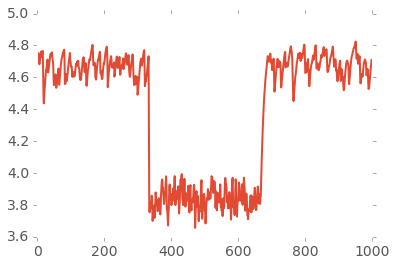

In [38]:
spikes_x, spikes_y, spikes_x_tc, spikes_y_tc,\
gamma, correlation, ssp1, stimulation,\
p,q,lowsp,vm = cortex.readSimulation(N, r, 0, G, 8*10, d1, d2, d3, before, after, WII, LTP, LTD, model, )
plt.plot(gamma)

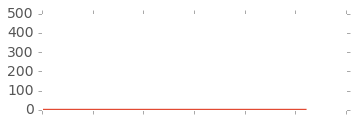

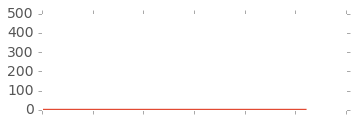

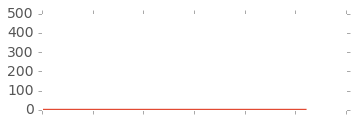

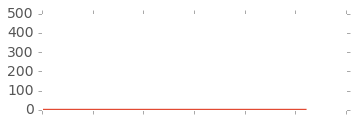

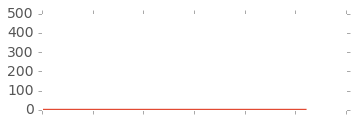

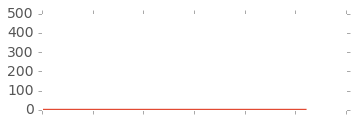

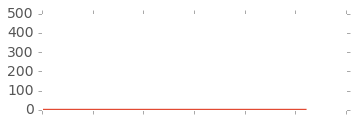

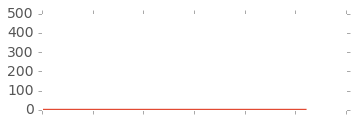

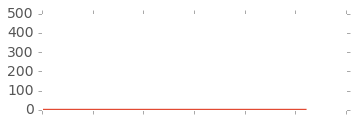

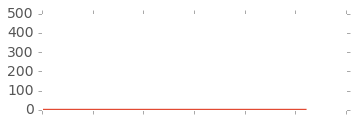

In [39]:
## WEIGHT DISTRIBUTION
for k in range(0,10):
    fig = plt.figure(figsize=(12,10))
    for i in range(0,len(SSP)):
        ax = fig.add_subplot(5,2,1+i)
        ax.set_ylim([0,500])
        if i<8: ax.set_xticklabels([])
        if i%2==1: ax.set_yticklabels([])
    #     ax.text(5000,1600,i*20)
        RON = ron_net(SSP[i][19700*4:21000*4], 0.013, 0.0001+k/10, 800, 10, model="aEIF")
        ax.plot(RON)
    plt.savefig(DIRECTORY + "_RON-10_adex%s.pdf"%str(k/10))

## PLOT RASTER_i

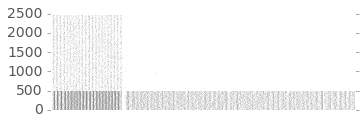

In [13]:
fig = plt.figure(figsize=(12,10))
for i in range(len(SSP)):
    ax = fig.add_subplot(5,2,1+i)
    start=findIndex2(SPX[i], 19700)
    end = findIndex2(SPX[i], 21000)
    ax = gr.plotRaster(SPX[i][start:end],SPY[i][start:end], ax)
    if i<8: ax.set_xticklabels([])
    if i%2==1: ax.set_yticklabels([])
plt.savefig(DIRECTORY + "_RASTER.png")

## PLOT WEIGHT DISTRIBUTION

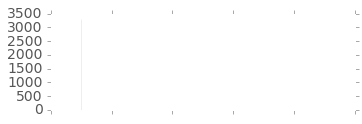

In [14]:
fig = plt.figure(figsize=(12,10))
for i in range(0,len(SSP)):
    ax = fig.add_subplot(5,2,1+i)
#     ax.set_ylim([0,20])
    if i<8: ax.set_xticklabels([])
    if i%2==1: ax.set_yticklabels([])
#     ax.text(5000,1600,i*20)
    count, bins, ignored = plt.hist(np.random.lognormal(0.0002,0.0001+i/10,100000), 100)#, normed=True, align='mid')
    ax.set_xlim([0,10])
plt.savefig(DIRECTORY + "_WD-10.pdf")

## RASTER GPU

In [15]:
start=findIndex2(SPX[0], 19700)
end = findIndex2(SPX[0], 21000)
print(start,end)
gr.plotRasterGPU(SPX[0][start:end],SPY[0][start:end])

847469 883608


## PLOT DECAY SIN

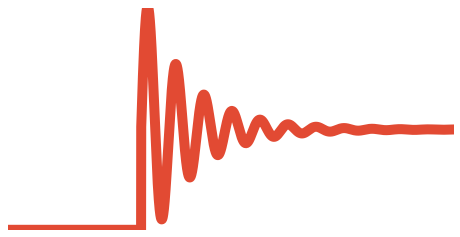

In [16]:
x= np.arange(0,100,0.01)
y=[]
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
for t in x:
    if t<30:
        y.append(0.5)
    else:
        y.append(np.sin(t-30)*np.exp(-(t-30)/10)+1.2)
ax.set_xticks([])
ax.set_yticks([])
ax.plot(y, linewidth=10)
plt.savefig(DIRECTORY + 'fig5-sin.pdf')


# GENERATE FIGURE 5

In [46]:
def plotFigure5(i, SSP, SPX, SPY, start, dur, w,ratio):
    RON =[]
    var = 0.2
    network = SSP[i][start*4:(start+dur)*4]
    RON=ron_net(SSP[i][start*4:(start+1000)*4], w, var, 1000, 10, model="IAF")
    starti = findIndex2(SPX[i], start)
    end = findIndex2(SPX[i], start+dur)
    
    # RASTER
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(311)
#     ax.set_ylabel('Neuron Index')
    ax.set_yticks([250,1500]),
#     ax.set_ylim([1500,4000])
    ax.set_yticks([250,1500])
    ax.set_yticklabels(['I', 'E'])
    ax = gr.plotRaster(SPX[i][starti:end],SPY[i][starti:end], ax)

    # LFP
    ax = plt.subplot(312)
    ax.set_ylim([0,80])
    ax.set_xticklabels([])
    ax.set_ylabel('LFP')
    ax.plot(xax(network,dur), network, color='grey')
    
    # RON
    ax = plt.subplot(313)
    ax.set_ylabel('Read-out')
    ax.set_xticks([0,0.3,0.5,1])
    ax.set_xlabel('Time [1s]')
    ax.plot(xax(network,dur),RON, color='#33cc66')
    
    print(DIRECTORY + 'ron_%s'%str(start))
#     plt.text(-0.4,270,'A', fontsize=16)
#     plt.text(-0.4,110,'B', fontsize=16)
#     plt.text(-0.4,-20,'C', fontsize=16)
    plt.tight_layout()
    plt.savefig(DIRECTORY + 'fig5-ron_%s-r-%d.pdf'%(str(start),ratio))


# W = 0.004
# i = 0
# plotFigure5(i, SSP, SPX, SPY, 9700, 1000, W)


/Users/GP1514/Dropbox/0000 - PhD/figures/20160224/ron_9700


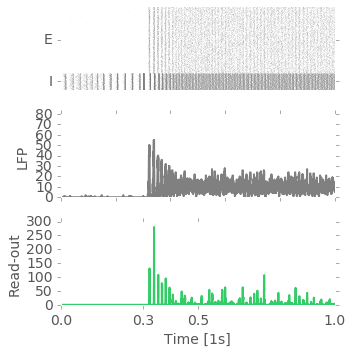

In [47]:

# for S in range(0,20,2):
#     spikes_x, spikes_y, _, _, _, _, _, _,_,_,_,_  = cortex.readSimulation(N, r, 0, G, 10*S, d1, d2, d3, before, after, WII, LTP, LTD, model, )
#     SPX.append(spikes_x)
#     SPY.append(spikes_y)
#     _,_,_,_,ssp  = cortex.readPSTH(N,r, G,S*10, it,binsize, d1, d2, d3, before, after, sigma, WII, LTP, LTD, model,coeff,RON='IAF', tau_m = 1)
#     SSP.append(ssp)
S = 140
N = 2500
for ratio in [15]:
    SSP = []
    SPX = []
    SPY = []
    FACT = 1
    LTD  = 4.7e-6 * FACT * N
    LTP = ratio * LTD

    spikes_x, spikes_y, spikes_x_tc, spikes_y_tc, gamma, correlation, ssp1, stimulation,p,q,lowsp,vm = cortex.readSimulation(N,r, 0, G, S, d1, d2, d3, before, after, WII, LTP, LTD, model)
    SPX.append(spikes_x)
    SPY.append(spikes_y)
    SSP.append(ssp1)
#     np.save(DIRECTORY +"SSP",SSP)
#     np.save(DIRECTORY +"SPX",SPX)
#     np.save(DIRECTORY +"SPY",SPY)

    W = 0.004
    i = 0
    plotFigure5(i, SSP, SPX, SPY, 9700, 1000, W,ratio)